<a href="https://colab.research.google.com/github/ChangjaeCHUNG/rl-study-w.-ns/blob/main/model-free%20control/model_free_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
ls

 custum_frozen_lake_env.py                   'q_learning.ipynb의 사본'
'monte_carlo_policy_iteration.ipynb의 사본'  'SARSA.ipynb의 사본'
 __pycache__/


In [2]:
from custum_frozen_lake_env import CustumFrozenLakeEnv
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Vizualize Function

In [ ]:
def display_q_value(value, title="State Action Value (Q) Function",map_type="8x8", fig_size = 12, char_size = 8): # Visualize q value
    n_state, n_action = value.shape

    if map_type == "8x8":
        nRow = 8
    elif map_type == "4x4":
        nRow = 4
    
    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])

    # Color
    high_color = np.array([1,1,0,0.8])
    low_color = np.array([0,0,1,0.8])
    
    fig = plt.figure(num=0,figsize=(fig_size,fig_size))
    plt.title(title,fontsize=char_size*2)  
    for i in range(nRow):
        for j in range(nRow):
            s = i*nRow+j
            min_q = np.min(value[s])
            max_q = np.max(value[s])
            for a in range(n_action):
                val = value[s,a]
                ratio = (val - min_q)/(max_q - min_q + 1e-10)
                clr = high_color*ratio + low_color*(1-ratio)
                if max_q -min_q <= 1e-3: clr = np.array([1,0,0,0.8])
                if a == 0: # Left arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+lft_tri, color=clr, ec='k'))
                    plt.text(j-0.4, i+0.1, "{:2.3f}".format(val), fontsize=char_size)
                if a == 1: # Down arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+dw_tri, color=clr, ec='k'))
                    plt.text(j-0.1, i+0.4, "{:2.3f}".format(val), fontsize=char_size)
                if a == 2: # Right arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+rgh_tri, color=clr, ec='k'))
                    plt.text(j+0.2, i+0.1, "{:2.3f}".format(val), fontsize=char_size)
                if a == 3: # Up arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+up_tri, color=clr, ec='k'))
                    plt.text(j-0.1, i-0.2, "{:2.3f}".format(val), fontsize=char_size)
    plt.xlim([-0.5,nRow-0.5])
    plt.xticks(range(nRow))
    plt.ylim([-0.5,nRow-0.5])
    plt.yticks(range(nRow))
    plt.gca().invert_yaxis()
    plt.show()
    
def display_episode(episode, fig_size = 8, char_size = 8, map_type="8x8"):
    
    if map_type == "8x8":
        nRow = 8
    elif map_type == "4x4":
        nRow = 4
    
    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])

    # Color
    start_color = np.array([1,0,0,0.8])
    finish_color = np.array([0,1,0,0.8])
    len_episode = len(episode)
    arr_len = 0.2

    fig = plt.figure(num=0,figsize=(fig_size,fig_size))
    plt.title("Episode",fontsize=char_size*2)  
    for e, (state, action, reward, done) in enumerate(episode):
        j = state%nRow
        i = (state - j)/nRow
        clr = start_color + (finish_color - start_color) * e / len_episode
        if action == 0: # Left arrow
            plt.arrow(j,i,-arr_len,0,color=clr,alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)
        if action == 1: # Down arrow
            plt.arrow(j,i,0,arr_len,color=clr,alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)
        if action == 2: # Right arrow
            plt.arrow(j,i,arr_len,0,color=clr,alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)
        if action == 3: # Up arrow
            plt.arrow(j,i,0,-arr_len,color=clr,alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)

    plt.xlim([-0.5,nRow-0.5])
    plt.xticks(range(nRow))
    plt.ylim([-0.5,nRow-0.5])
    plt.yticks(range(nRow))
    plt.gca().invert_yaxis()
    plt.show()

# Environment

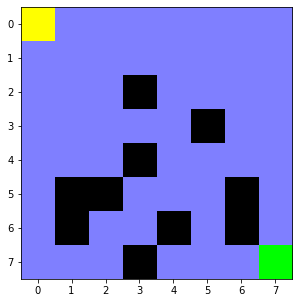

In [ ]:
env = CustumFrozenLakeEnv(map_name="8x8")
env.seed(seed=0)
np.random.seed(seed=0)
obs_space = env.observation_space
n_state = obs_space.n
act_space = env.action_space
n_action = act_space.n

map = env.desc

def str_to_color(word):
    if word == b'S': return (255,255,0)
    if word == b'F': return (127,127,255)
    if word == b'H': return (0,0,0)
    if word == b'G': return (0,255,0)

colormap = np.array([[str_to_color(word) for word in line] for line in map])

plt.figure(figsize = (5,5))
plt.imshow(colormap)
plt.show()

# Value Iteration with Q Value

Value iteration find the optimal value function of MDPs using 

$V_{k+1}(s) = \max_{a} \left[r(s,a,s') + \gamma V_{k}(s') \right] P(s'|s,a)$

However, we need model to obtain the optimal policy from the optimal value function

$\pi'(a|s) = \arg\max_{a} \sum_{s'} \left(r(s,a,s') + V(s')\right) P(s'|s,a)$

If we compute Q(s,a) instead of V(s), then, we don't need a model for policy improvement

Greedy policy improvement over Q(s,a) is model free

$\pi'(a|s) = \arg\max_{a} Q(s,a)$

Before looking model free value iteration, let's see how value iteration works with state action value (Q value) when a model is given

To implement value iteration with Q value, we have to use the Bellman eqaution for Q value as follows:

$Q_{k+1}(s,a) = \sum_{s'} \left[r(s,a,s') + \gamma \max_{a'} Q_{k}(s',a') \right] P(s'|s,a)$


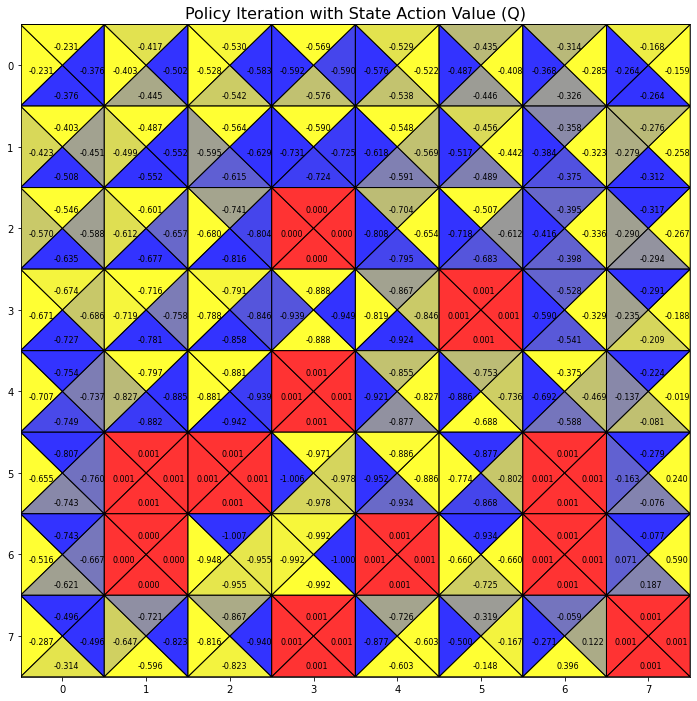

In [ ]:
def q_value_iteration(env,gamma=0.99,epsilon=1e-6):
    
    # Extract environment information
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_action = act_space.n
    
    P = np.zeros((n_state,n_action,n_state))
    r = np.zeros((n_state,n_action,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
                r[s][a][next_s]=reward

    q = np.random.uniform(size=(n_state,n_action))
    
    while True: 
        v = np.max(q,axis=1)
        q_prime = np.sum((r+gamma*np.tile(v[np.newaxis,np.newaxis,:],reps=(n_state,n_action,1)))*P,axis=2)
        dist = np.max(np.max(np.abs(q-q_prime)))
        q = q_prime
        if dist < epsilon:
            break

    policy = np.zeros((n_state,n_action))
    policy[np.arange(n_state),np.argmax(q,axis=1)] = 1
    
    return policy, q

if __name__=='__main__': 
    policy,q = q_value_iteration(env)
    display_q_value(q,title="Policy Iteration with State Action Value (Q)")

# Monte Carlo Policy Iteration

The update rule for Q value is same as below

$Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (G_{t} - Q_{old}(S_{t}, A_{t}))$

We can update our estimator after the episode is terminated

Given $(S_{0}, A_{0}, R_{1}, S_{1}, A_{1}, R_{2}, \dots, S_{T}, A_{T}, R_{T+1}, S_{T+1})$,

$G_{t}$ can be computed using

$G_t = R_{t+1} + \gamma G_{t+1}$

$\epsilon$-greedy Policy Improvement

$\pi(a|s) = \frac{\epsilon}{m} + (1-\epsilon) \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$

In [ ]:
class MCAgent():
    def __init__(self, n_state, n_action, epsilon=0.3, alpha=0.1, gamma=0.99):
        
        self.n_state = n_state
        self.n_action = n_action
        
        # initial Q value
        self.q = np.zeros([n_state,n_action])
        
        # memory for saving trajectory
        self.samples = []
        
        self.epsilon = epsilon # initial epsilon
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor 

    def save_sample(self, state, action, reward, done): # Save experience (s, a, r)
        self.samples.append([state, action, reward, done])
        
    def update_value(self):
        q_old = self.q
        g = 0
        G = q_old
        for t in reversed(range(len(self.samples))): # reverse way
            state, action, reward, _ = self.samples[t]
            g = reward + self.gamma * g # r + gamma G_t
            G[state][action] = g # Store it
        
        self.q = q_old + self.alpha*(G - q_old) # Update
        self.samples = [] # empty memory
        
    def update_policy(self, update_rate):
        self.epsilon = self.epsilon*np.min([update_rate,1]) # Decay epsilon
        
    def get_action(self, state): # epsilon Greedy action
        if np.random.uniform() < self.epsilon: # choose random action with probability epsilon 
            action = np.random.randint(0, high=self.n_action)
        else: # choose greedy action with probability (1-epsilon)
            action = np.argmax(self.q[state])
        return action

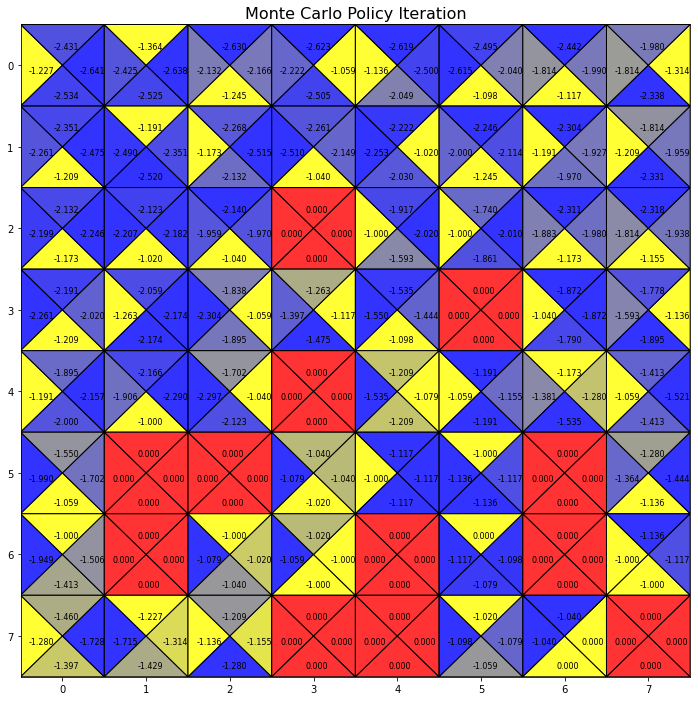

In [ ]:
mcagent = MCAgent(n_state,n_action)

n_episode = 10000
episode_last = []

for episode in range(n_episode):
    state = env.reset()
    action = mcagent.get_action(state)
    done = False
    while not done: # If the epsiodes finish, then escape the loop    
        
        next_state, reward, done, info = env.step(action)
        next_action = mcagent.get_action(next_state) # Get next action

        mcagent.save_sample(state, action, reward, done) # Store samples
        
        state = next_state
        action = next_action
        if next_state == 63: episode_last = mcagent.samples[:]
    mcagent.update_value() # Update Q value using sampled epsiode
    mcagent.update_policy(1000/(episode+1)) # Decaying epsilon
display_q_value(mcagent.q,title="Monte Carlo Policy Iteration")

In [ ]:
episode_last

[[0, 0, -0.03, False],
 [0, 0, -0.03, False],
 [0, 0, -0.03, False],
 [8, 1, -0.03, False],
 [9, 3, -0.03, False],
 [10, 0, -0.03, False],
 [2, 1, -0.03, False],
 [1, 3, -0.03, False],
 [2, 1, -0.03, False],
 [3, 2, -0.03, False],
 [4, 0, -0.03, False],
 [3, 2, -0.03, False],
 [3, 2, -0.03, False],
 [4, 0, -0.03, False],
 [3, 2, -0.03, False],
 [4, 0, -0.03, False],
 [4, 0, -0.03, False],
 [12, 2, -0.03, False],
 [20, 1, -0.03, False],
 [28, 1, -0.03, False],
 [36, 1, -0.03, False],
 [37, 3, -0.03, False],
 [38, 3, -0.03, False],
 [39, 1, -0.03, False],
 [47, 1, -0.03, False],
 [47, 1, -0.03, False],
 [55, 2, 1.0, True]]

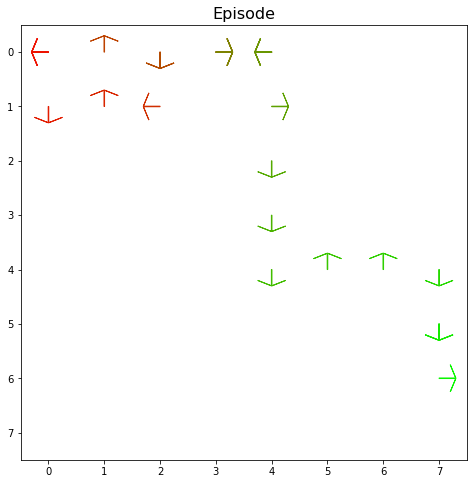

In [ ]:
display_episode(episode_last)

# SARSA

The update rule for Q value is same as below

$Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (R_{t+1} + \gamma Q_{old}(S_{t+1},A_{t+1}) - Q_{old}(S_{t}, A_{t}))$

We can update our estimator online, just $(S_{t},A_{t},R_{t+1},S_{t+1},A_{t+1})$ is needed.

TD target is $R_{t+1} + \gamma Q(S_{t+1},A_{t+1})$

TD error is $R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_{t},A_{t})$

$\epsilon$-greedy Policy Improvement

$\pi(a|s) = \frac{\epsilon}{m} + (1-\epsilon) \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$

In [ ]:
class SARSAAgent():
    def __init__(self, n_state, n_action, epsilon=0.3, alpha=0.5, gamma=0.99):
        
        self.n_state = n_state
        self.n_action = n_action
        
        # initial Q value
        self.q = np.zeros([n_state,n_action])
        
        self.epsilon = epsilon # initial epsilon
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor

    def update_value(self, state, action, reward, next_state, next_action, done):
        q_old = self.q[state][action]
        if done: # If the next state is terminal, don't add our estimation
            td_target = reward # This is the exact Q value at the current state
        else:
            td_target = reward + self.gamma * self.q[next_state][next_action] # r + gamma * Q(S',A')
        td_error = td_target - q_old # TD error
        self.q[state, action] = q_old + self.alpha * td_error # Update Q(S,A)

    def update_policy(self, update_rate):
        self.epsilon = self.epsilon*np.min([update_rate,1])
        
    def get_action(self, state):
        if np.random.uniform() < self.epsilon:
            action = np.random.randint(0, high=self.n_action)
        else:
            action = np.argmax(self.q[state])
        return action
    


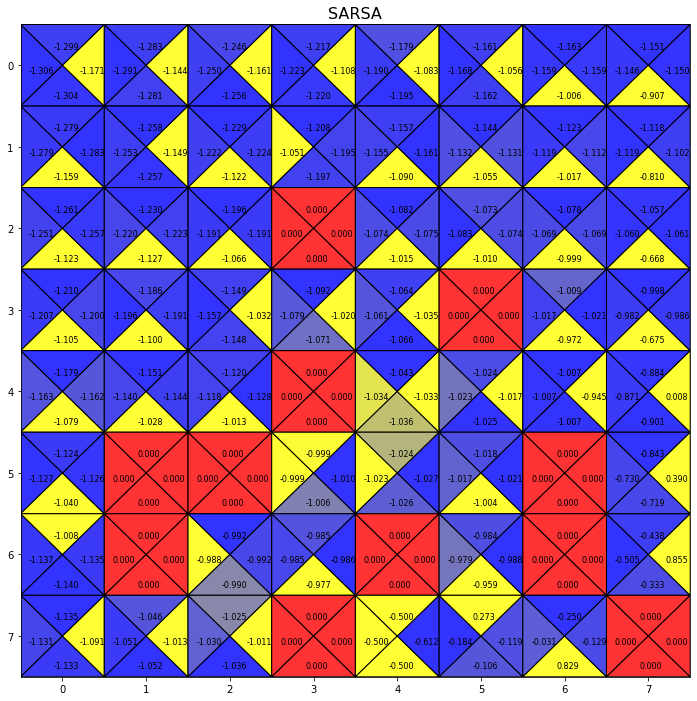

In [ ]:
sarsaagent = SARSAAgent(n_state,n_action)

n_episode = 10000
for episode in range(n_episode):
    state = env.reset()
    action = sarsaagent.get_action(state)
    done = False
    while not done:    
        
        next_state, reward, done, info = env.step(action)
        next_action = sarsaagent.get_action(next_state)

        sarsaagent.update_value(state, action, reward, next_state, next_action, done) # Online Update!!
        
        state = next_state
        action = next_action
    
    sarsaagent.update_policy(500/(episode+1)) # Decaying epsilon per episodes
display_q_value(sarsaagent.q,title="SARSA")

# Q Learning

The update rule for Q value is same as below

$Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a') - Q_{old}(S_{t}, A_{t}))$

We can update our estimator online, just $(S_{t},A_{t},R_{t+1},S_{t+1})$ is needed.
$A_{t+1}$ is not needed.

TD target is $R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a')$

TD error is $R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a') - Q(S_{t},A_{t})$

$\epsilon$-greedy Policy Improvement

$\pi(a|s) = \frac{\epsilon}{m} + (1-\epsilon) \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$

In [ ]:
class  QLearningAgent():
    def __init__(self, n_state, n_action, alpha=0.5, gamma=0.99,
                 exploration="EpsGrdy", epsilon=0.3):
        
        self.n_state = n_state
        self.n_action = n_action
        
        # initial Q value
        self.q = np.zeros([n_state,n_action])
        
        self.alpha = alpha
        self.gamma = gamma
        self.exploration = exploration
        if self.exploration == "EpsGrdy":
            self.epsilon = epsilon

    def update_value(self, state, action, reward, next_state, done): #(S,A,R,S')
        q_old = self.q[state][action]
        # TD target
        if done:
            td_target = reward
        else:
            td_target = reward + self.gamma * np.max(self.q[next_state])
        td_error = td_target - q_old # TD error
        self.q[state, action] = q_old + self.alpha * td_error # Update Q

    def update_policy(self, update_rate):
        if self.exploration == "EpsGrdy":
            self.epsilon = np.min([update_rate,1])
            
    def update_alpha(self, update_rate):
        self.alpha = np.min([update_rate,1])
        
    def get_action(self, state):
        if self.exploration == "EpsGrdy":
            if np.random.uniform() < self.epsilon:
                action = np.random.randint(0, high=self.n_action)
            else:
                action = np.argmax(self.q[state])
        elif self.exploration == "Random":
            action = np.random.randint(0, high=self.n_action)
        return action
    



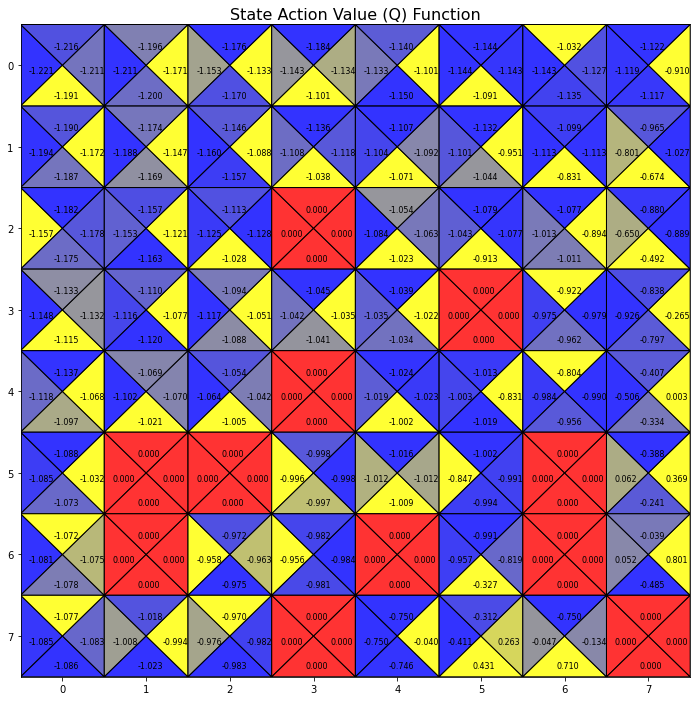

In [ ]:
qlearningagent = QLearningAgent(n_state,n_action)

n_episode = 10000
for episode in range(n_episode):
    state = env.reset()
    action = qlearningagent.get_action(state)
    done = False
    while not done:    
        
        next_state, reward, done, info = env.step(action)
        next_action = qlearningagent.get_action(next_state)

        qlearningagent.update_value(state, action, reward, next_state, done)
        
        state = next_state
        action = next_action
    qlearningagent.update_policy(1000/(episode+1))


display_q_value(qlearningagent.q)

# One-step update with three methods

In [ ]:
def one_step_update(agent, episode, name):
    if name == 'MC':
        agent.samples = episode[:] 
        agent.update_value()

    if name == 'SARSA':
        for e in range(len(episode)):
            state, action, reward, done = episode[e]
            if not done: next_state, next_action, _, _ = episode[e+1]

            agent.update_value(state, action, reward, next_state, next_action, done)
    
    if name == 'QL':
        for e in range(len(episode)):
            state, action, reward, done = episode[e]
            if not done: next_state, _, _, _ = episode[e+1]

            agent.update_value(state, action, reward, next_state, done)


m_a = MCAgent(n_state,n_action)
s_a = SARSAAgent(n_state,n_action)
q_a = QLearningAgent(n_state,n_action)

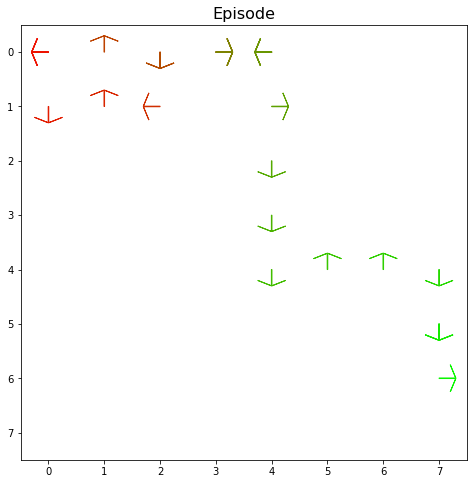

In [ ]:
display_episode(episode_last)

In [ ]:
for i in range(5):
    one_step_update(m_a, episode_last, "MC")
    display_q_value(m_a.q)

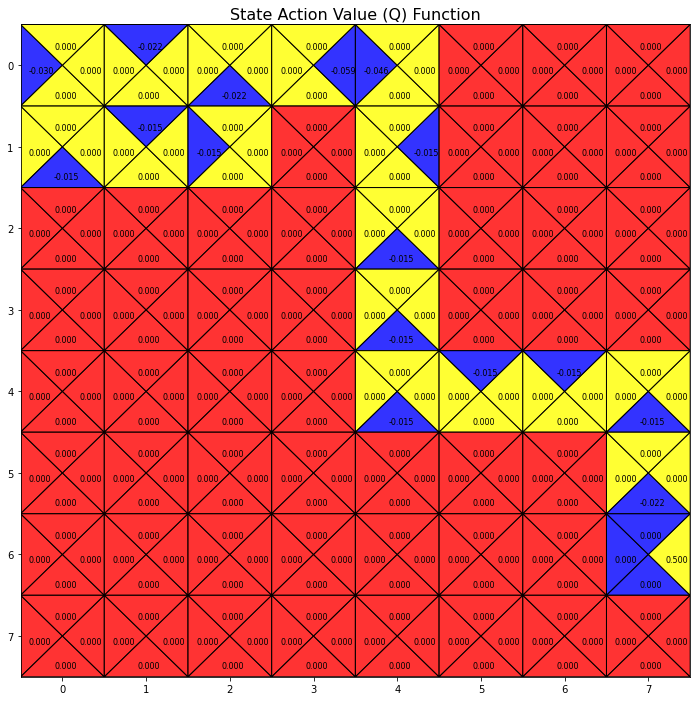

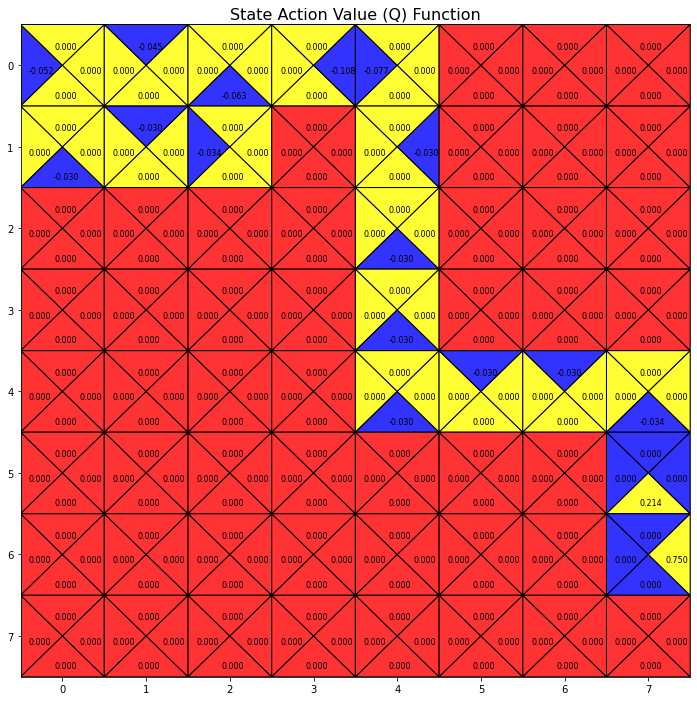

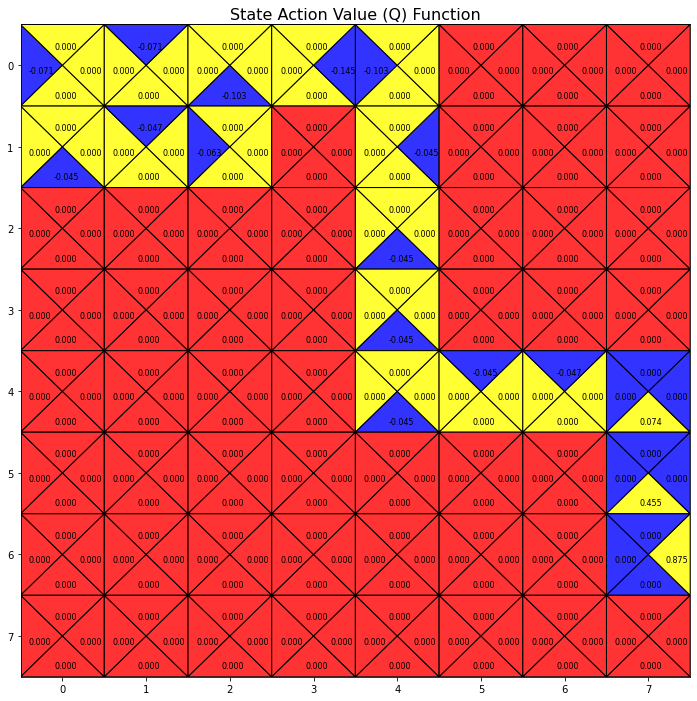

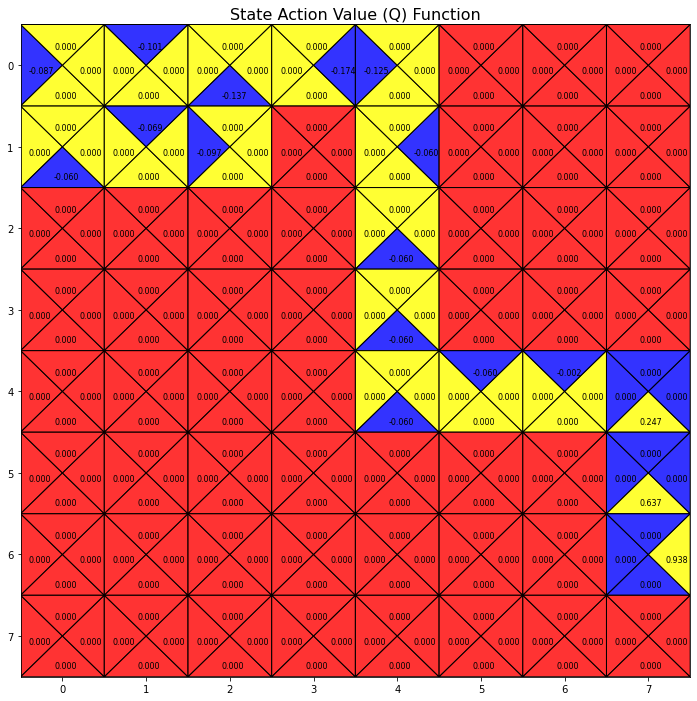

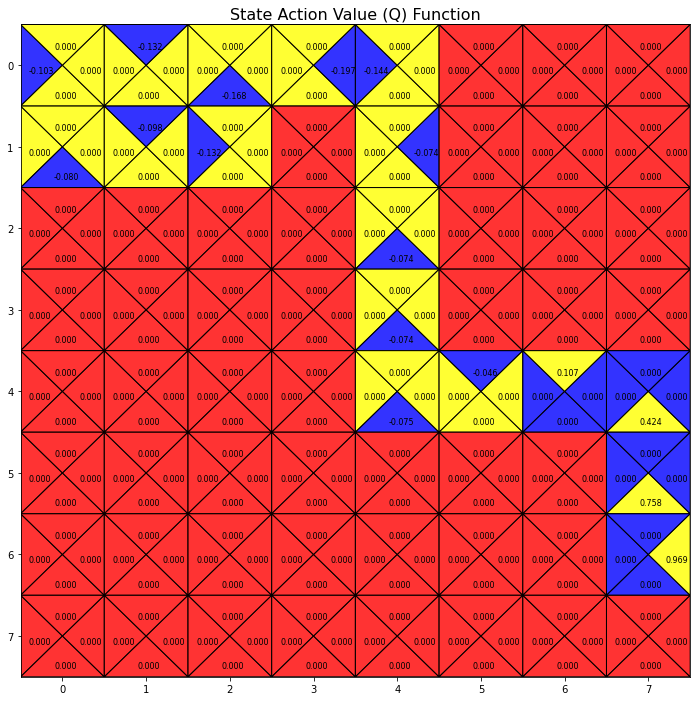

In [ ]:
for i in range(5):
    one_step_update(s_a, episode_last, "SARSA")
    display_q_value(s_a.q)

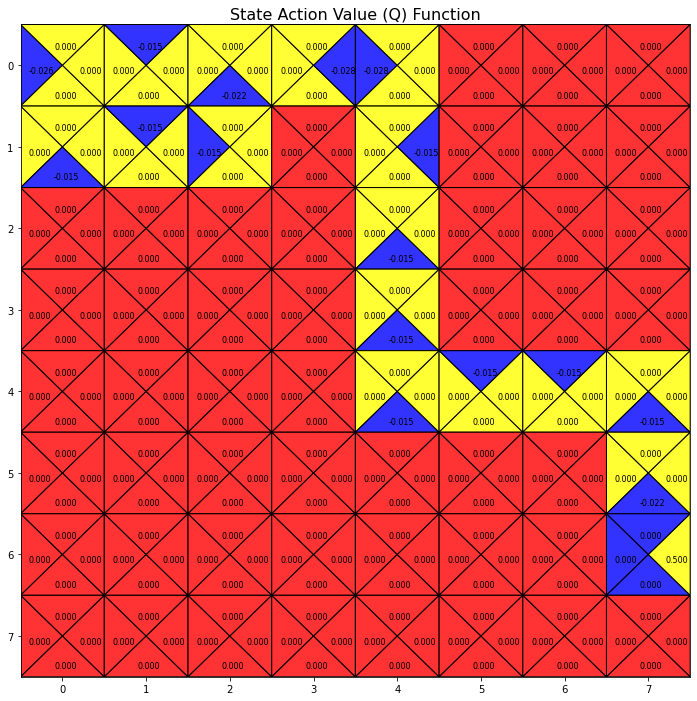

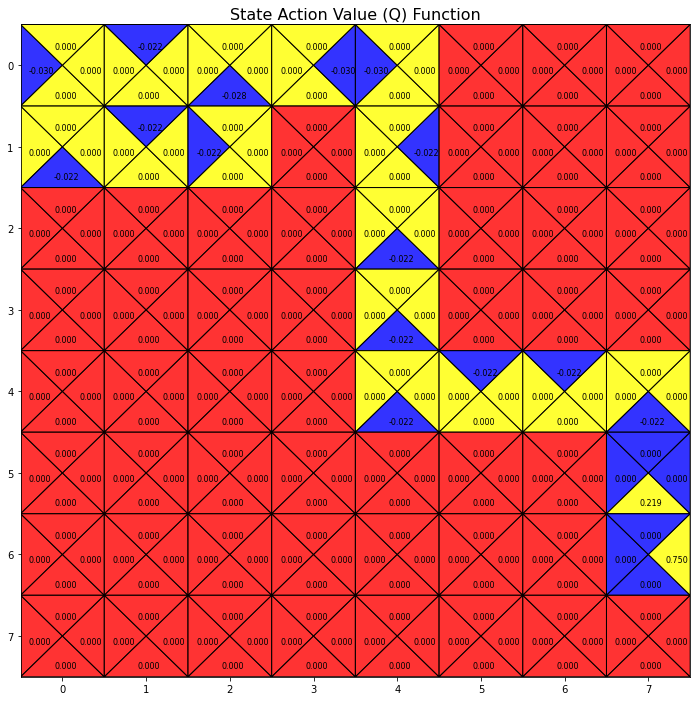

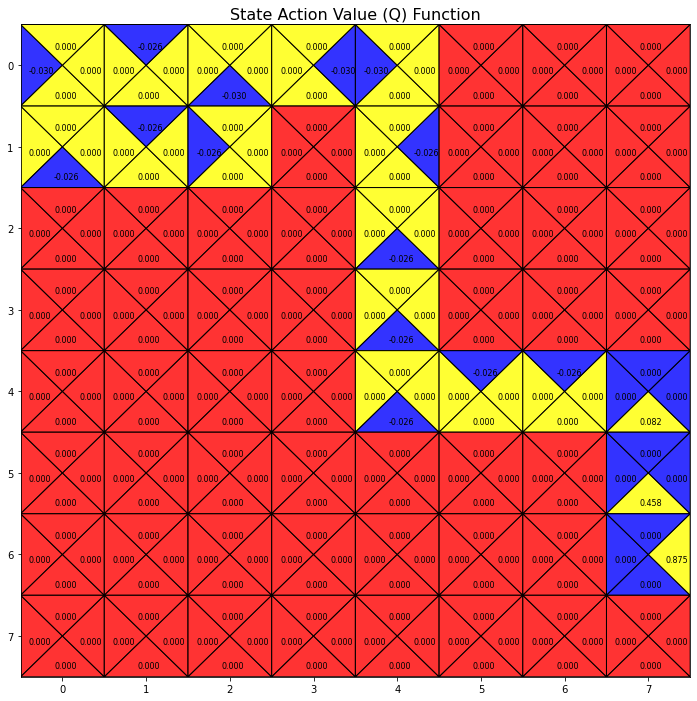

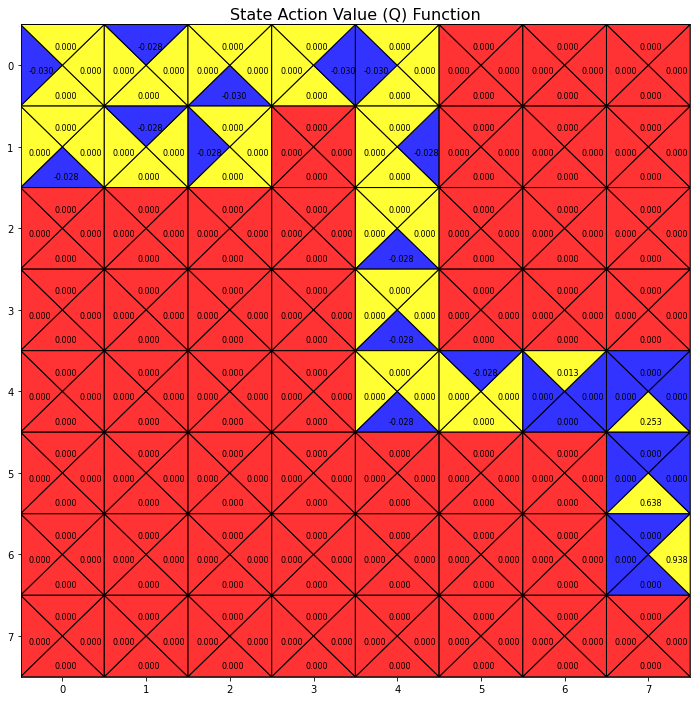

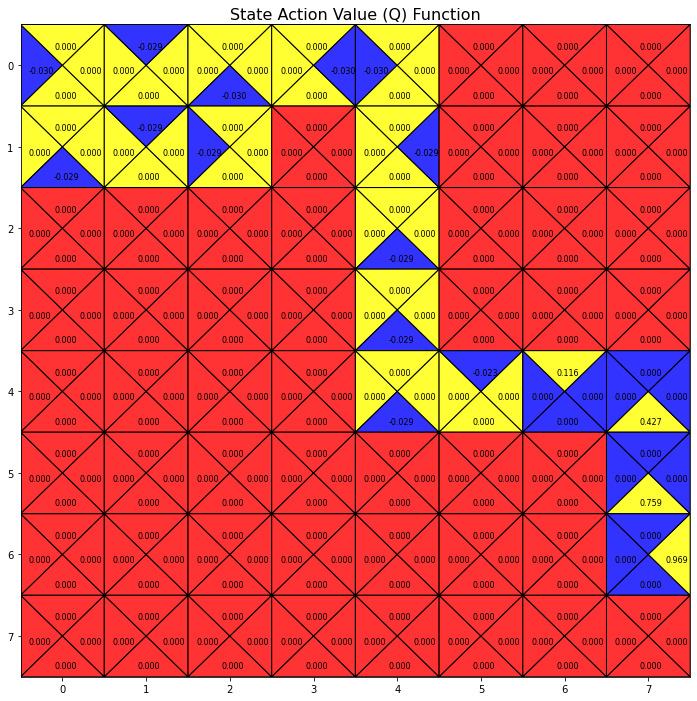

In [ ]:
for i in range(5):
    one_step_update(q_a, episode_last, "QL")
    display_q_value(q_a.q)